# Vaihe 1

### Kiinnostavat tutkimuskysymykset
1. Mitkä genret ovat olleet suosittuja milloin?
2. Millaisia ovat suositut näyttelijäparit?
3. Korrelaatio arvioiden ja tuoton välillä. Voiko elokuva olla huonosti arvioitu mutta silti tuottoisa tai toisin päin?
4. Jos tekisimme elokuvan, millainen sen kannattaa olla, että se on tuottoisa ja suosittu?

# Vaihe 2

### Aineiston kuvaus
Aineisto löydettiin Kagglesta ja se sisältää tietoa elokuvista IMDB palvelussa.

Linkki aineistoon: [LINKKI](https://www.kaggle.com/datasets/ashpalsingh1525/imdb-movies-dataset)


In [171]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# set display options
pd.set_option('display.max_colwidth', None)

dataset = pd.read_csv('Datasets/imdb_movies.csv')

# TODO: Fixaa tää silleen et selitetään otsikoiden tarkoitus
# Print dataframe columns
print("Aineiston otsikot:")
print(dataset.columns)
print("Otsikoiden tyypit:")
print(dataset.dtypes)
print("Aineiston muoto:")
print(dataset.shape)
amount_of_rows_pre = dataset.shape[0]


Aineiston otsikot:
Index(['names', 'date_x', 'score', 'genre', 'overview', 'crew', 'orig_title',
       'status', 'orig_lang', 'budget_x', 'revenue', 'country'],
      dtype='object')
Otsikoiden tyypit:
names          object
date_x         object
score         float64
genre          object
overview       object
crew           object
orig_title     object
status         object
orig_lang      object
budget_x      float64
revenue       float64
country        object
dtype: object
Aineiston muoto:
(10178, 12)


#### Aineiston otsikot:
- names:        Elokuvan nimi englanniksi
- date_x:       Elokuvan julkaisupäivämäärä
- score:        IMDB-käyttäjien antaman pistemäärän keskiarvo 
- genre:        Elokuvan genre
- overview:     Elokuvan kuvaus englanniksi
- crew:         Elokuvan näyttelijät ja heidän esittämät hahmot. esim. (näyttelijä, hahmo, näyttelijä, hahmo)
- orig_title:   Elokuvan nimi alkuperäisellä kielellä
- status:       Elokuvan tilanne. (Kaikki havainnot ovat julkaistu)
- orig_lang:    Elokuvan alkuperäiskieli
- budget_x:     Elokuvan budjetti (USD)
- revenue:      Elokuvan bruttotuotto (USD)
- country:      Elokuvan julkaisumaa

Aineistossa on siis 12 otsikkoa ja 10178 havaintoa.


Osa aineiston datasta on epäilyttävää. Esimerkiksi 144 elokuvista on saanut 0.0 arvostelun, ja niiden kaikkien tuotto on tasan $175,269,998.80.
Aineistossa on myös 9 elokuvaa 100.0 arvioinnilla, ja niistä jokaisen budjetti on $201,000,000.0 ja tuotto tasan $156,932,3843.8.

Aineiston julkaisija on ilmeisesti käyttänyt jotain knn keinoa aineiston täyttämiseen. Tämä täytyy ottaa huomioon myöhemmin.



# Vaihe 3
## Aineiston esikäsittely

#### Huonojen havaintojen poisto

In [172]:
# Tässä poistetaan ne havainnot joissa on tyhjiä arvoja tai arvostelu on 0.0
dataset = dataset.dropna()
dataset = dataset[~dataset['score'].isin([1.0, 100.0])]
print(dataset.shape)
amount_of_rows_post = dataset.shape[0]
print(f"Poistettu {amount_of_rows_pre - amount_of_rows_post} riviä, joissa oli tyhjiä arvoja tai arvostelu oli 0.0 tai 100.0")

(10044, 12)
Poistettu 134 riviä, joissa oli tyhjiä arvoja tai arvostelu oli 0.0 tai 100.0


#### Avataan näyttelijät
Emme ole kiinnostuneita näyttelijöiden hahmoista, joten poistetaan ne aineistosta.

In [173]:
print("1. elokuvan näyttelijät:")
print(dataset['crew'].head(1))

1. elokuvan näyttelijät:
0    Michael B. Jordan, Adonis Creed, Tessa Thompson, Bianca Taylor, Jonathan Majors, Damien Anderson, Wood Harris, Tony 'Little Duke' Evers, Phylicia Rashād, Mary Anne Creed, Mila Davis-Kent, Amara Creed, Florian Munteanu, Viktor Drago, José Benavidez Jr., Felix Chavez, Selenis Leyva, Laura Chavez
Name: crew, dtype: object


In [174]:
# Tässä avataan näyttelijät. Näyttelijän hahmo on listattu näyttelijän jälkeen. (esim. Tom Cruise, Ethan Hunt, ...)
dataset['crew'] = dataset['crew'].str.split(', ')
# Poista joka toinen alkio
dataset['crew'] = dataset['crew'].apply(lambda x: x[::2])
print("1. elokuvan näyttelijät:")
print(dataset['crew'].head(1))

1. elokuvan näyttelijät:
0    [Michael B. Jordan, Tessa Thompson, Jonathan Majors, Wood Harris, Phylicia Rashād, Mila Davis-Kent, Florian Munteanu, José Benavidez Jr., Selenis Leyva]
Name: crew, dtype: object


Crew -sarake sisältää siis nyt vain näyttelijät ilman hahmoja

# Vaihe 4
### Aineiston analysointi

In [175]:
#  JOKAISESSA ANALYSOINTIKOHDASSA TEHDÄÄN AINEISTOSTA KOPIO, ETTEI MYÖHEMMÄT KOHDAT MUUTU

#### Mitkä genret ovat suosittuja milloin

Found 19 unique genres
   year  Action  Adventure  Animation  Comedy  Crime  Documentary  Drama  \
0  2023       1          0          0       0      0            0      1   
1  2022       1          1          0       0      0            0      0   
2  2023       0          1          1       1      0            0      0   
3  2023       0          1          1       1      0            0      0   
4  2023       1          0          0       0      0            0      0   

   Family  Fantasy  History  Horror  Music  Mystery  Romance  Science Fiction  \
0       0        0        0       0      0        0        0                0   
1       0        0        0       0      0        0        0                1   
2       1        1        0       0      0        0        0                0   
3       1        1        0       0      0        0        0                0   
4       0        0        0       0      0        0        0                0   

   TV Movie  Thriller  War  Weste

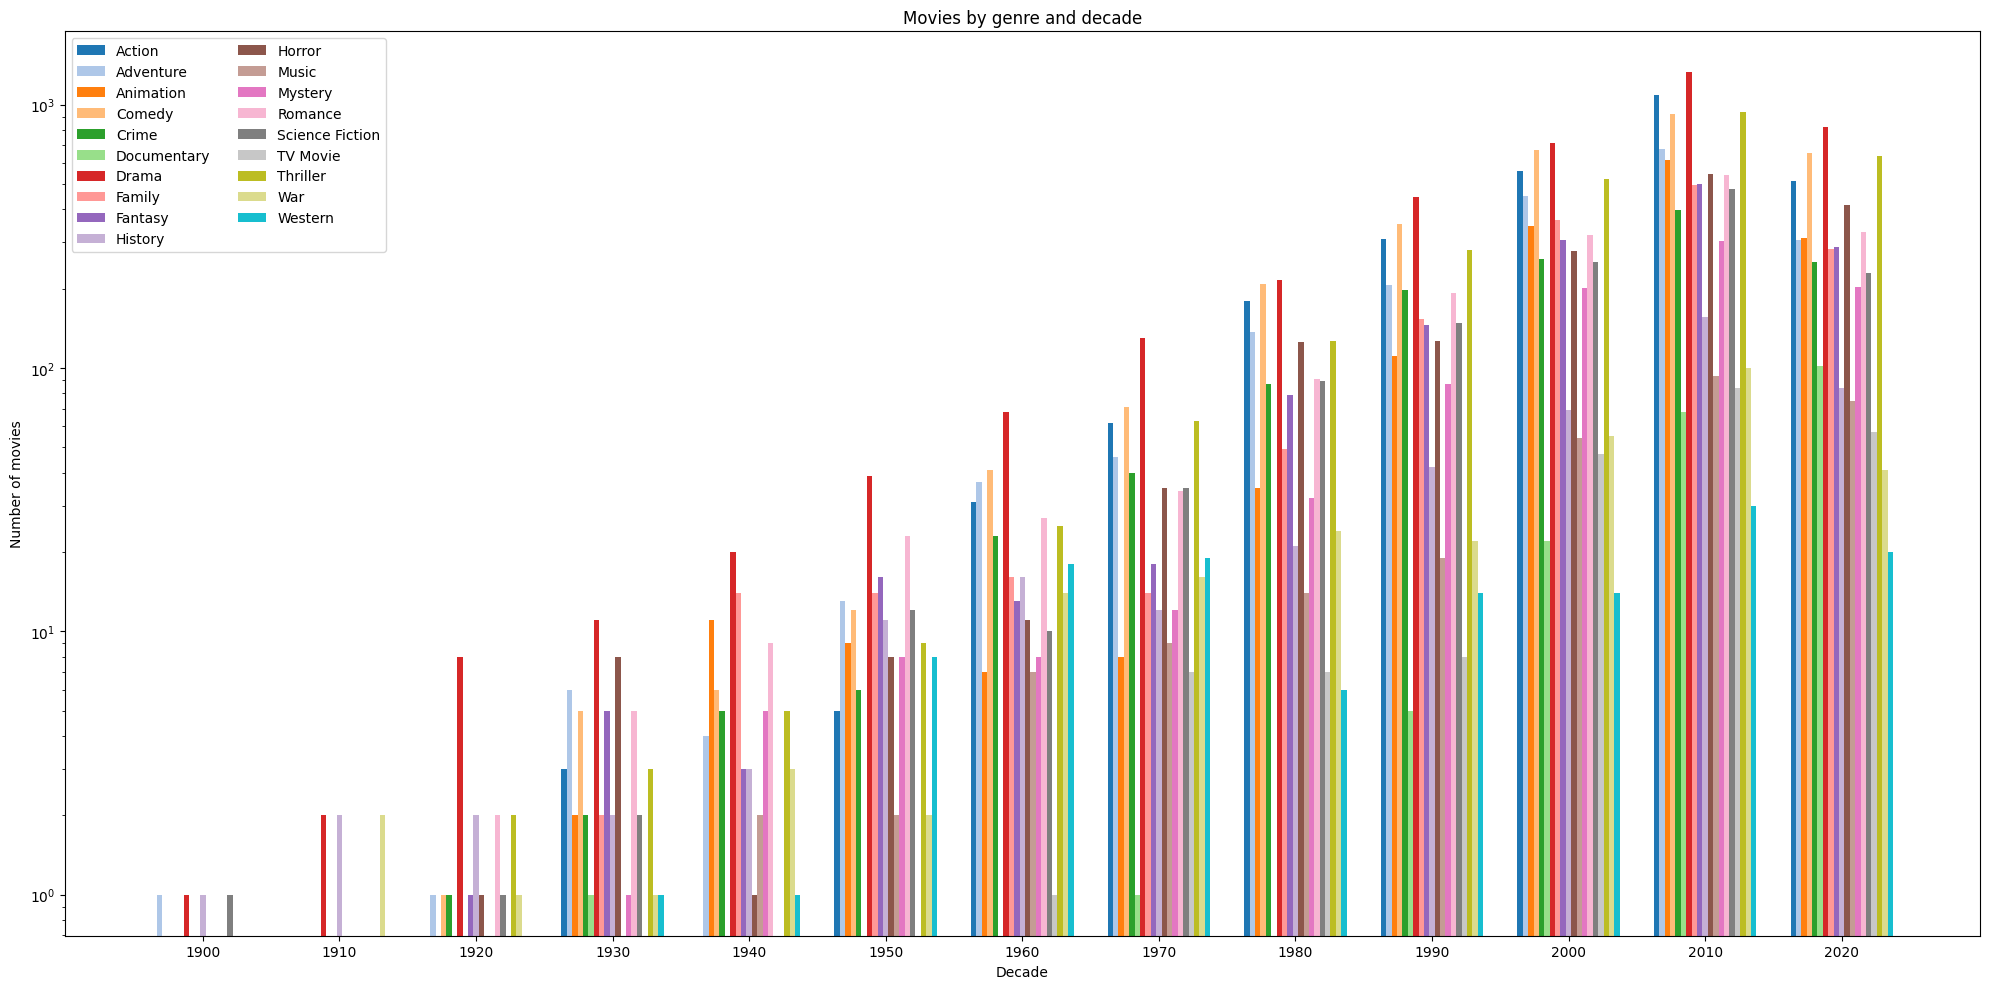

In [176]:
dataset_genre = dataset.copy()

# Drop description column
dataset_genre = dataset_genre.drop(columns=['overview'])

# Extract year from the release date
dataset_genre['date_x'] = pd.to_datetime(dataset_genre['date_x'])
dataset_genre['year'] = dataset_genre['date_x'].dt.year

# Extract all individual genres from the genre column
all_genres = []
for genre_string in dataset_genre['genre']:
    # Split on comma and remove any non-standard whitespace
    genres = [g.strip() for g in genre_string.split(',')]
    all_genres.extend(genres)

# Get unique genres and sort them
unique_genres = sorted(list(set(all_genres)))
print(f"Found {len(unique_genres)} unique genres")

# Create a new dataframe with a column for each genre
genres = pd.DataFrame(index=dataset_genre.index)
for genre in unique_genres:
    genres[genre] = dataset_genre['genre'].apply(lambda x: 1 if genre in x else 0)

# Join the original dataset with the genre dataframe
dataset_genre = dataset_genre.join(genres)

# Drop unnecessary columns
dataset_genre = dataset_genre.drop(columns=['genre', 'crew', 'names', 'orig_title', 'status', 'orig_lang', 'budget_x', 'score', 'date_x', 'revenue', 'country'])

# Print the first few rows of the dataset
print(dataset_genre.head())
print(dataset_genre.shape)

# Change the year of a movie to the decade it was released in
for row in dataset_genre.itertuples():
    dataset_genre.at[row.Index, 'year'] = row.year - (row.year % 10)


# --- PLOT ---
# Group by decade and sum the genre columns
dataset_genre = dataset_genre.groupby('year').sum()

# Create a colormap for the genres
colormap = plt.cm.tab20

# Plot the data
plt.figure(figsize=(20, 10))
bar_width = 0.75 / len(dataset_genre.columns)
x = np.arange(len(dataset_genre.index))

for i, genre in enumerate(dataset_genre.columns):
    plt.bar(x + i * bar_width, dataset_genre[genre], 
            width=bar_width, label=genre, color=colormap(i % 20))

plt.xticks(x + bar_width * len(dataset_genre.columns) / 2 - bar_width/2, dataset_genre.index)
plt.legend(loc='upper left', ncol=2)
plt.title('Movies by genre and decade')
plt.xlabel('Decade')
plt.ylabel('Number of movies')
plt.yscale('log')
plt.tight_layout()
plt.show()

##### Analyysi:
Kaavio on logaritminen. Voidaan päätellä, että ylipäänsä elokuvien määrä on lisääntynyt vuosien saatossa. 2010 -vuonna elokuvia tehtiin noin 1000 -kertainen määrä vuoteen 1900 verrattuna. Myös genrejen kirjo on kasvanut.

#### Millaisia ovat suositut näyttelijäparit?

In [179]:
from itertools import combinations
from collections import Counter
from collections import defaultdict
import pandas as pd
import numpy as np

# Kopioidaan aineisto 
dataset_actors = dataset.copy()

# Extract all individual genres from the genre column
all_genres = []
for genre_string in dataset_actors['genre']:
    # Split on comma and remove any non-standard whitespace
    genres = [g.strip() for g in genre_string.split(',')]
    all_genres.extend(genres)

# Get unique genres and sort them
unique_genres = sorted(list(set(all_genres)))
print(f"Found {len(unique_genres)} unique genres")

# Create a new dataframe with a column for each genre
genres = pd.DataFrame(index=dataset_actors.index)
for genre in unique_genres:
    genres[genre] = dataset_actors['genre'].apply(lambda x: 1 if genre in x else 0)

# Join the original dataset with the genre dataframe
dataset_actors = dataset_actors.join(genres)

# Drop unnecessary columns
dataset_actors = dataset_actors.drop(columns=['names', 'orig_title', 'status', 'orig_lang', 'date_x', 'overview', 'genre'])
# Analyzing actor combinations and their impact on movie metrics
print("Analyzing actor combinations and their impact on movies...")

import matplotlib.pyplot as plt

# Create a dictionary to store the average score for each actor combination
actor_scores = defaultdict(list)

# Iterate through each row in the dataset
for _, row in dataset_actors.iterrows():
    crew = row['crew']
    score = row['score']
    revenue = row['revenue']
    budget = row['budget_x']
    country = row.get('country', '')  # Get country info if available
    
    # Skip Korean films
    if country in ['KR', 'South Korea', 'Korea']:
        continue
    
    # Get all possible pairs of actors in the crew
    actor_combinations = list(combinations(crew, 2))
    
    # Store the score for each actor combination
    for combo in actor_combinations:
        actor_scores[combo].append({'score': score, 'revenue': revenue, 'budget': budget})

# Calculate the average score for each actor combination
actor_combination_scores = {}
for combo, movies in actor_scores.items():
    if len(movies) >= 2:  # Only consider combinations that appear in at least 2 movies
        avg_score = sum(movie['score'] for movie in movies) / len(movies)
        actor_combination_scores[combo] = avg_score

# Convert to pandas Series for easier analysis
actor_combination_scores = pd.Series(actor_combination_scores)

# Find top actor combinations by score
top_combinations = actor_combination_scores.nlargest(20)
print("\nTop 20 actor combinations by average score:")
print(top_combinations)

# Find best actor pair
best_combo = top_combinations.index[0]
best_score = top_combinations.iloc[0]
print(f"\nBest actor combination: {best_combo[0]} and {best_combo[1]} with average score: {best_score:.1f}")

# Calculate how many times each actor pair appears together
actor_pair_counts = Counter(tuple(sorted(pair)) for _, row in dataset_actors.iterrows() 
                           for pair in combinations(row['crew'], 2))

# Find actor pairs that appear in multiple movies together
frequent_pairs = {pair: count for pair, count in actor_pair_counts.items() if count > 1}
print(f"\nFound {len(frequent_pairs)} actor pairs that appear in multiple movies together")

# Get the top 10 most frequent actor pairs
top_10_pairs = sorted(frequent_pairs.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 actor pairs by number of movies together:")
for pair, count in top_10_pairs:
    # Check if the pair exists in actor_scores and has movies before calculating averages
    if pair in actor_scores and len(actor_scores[pair]) > 0:
        avg_metrics = {
            'score': sum(movie['score'] for movie in actor_scores[pair]) / len(actor_scores[pair]),
            'revenue': sum(movie['revenue'] for movie in actor_scores[pair]) / len(actor_scores[pair]),
            'budget': sum(movie['budget'] for movie in actor_scores[pair]) / len(actor_scores[pair])
        }
    print(f"{pair[0]} and {pair[1]}: {count} movies together")
    print(f"  Average score: {avg_metrics['score']:.1f}")
    print(f"  Average revenue: ${avg_metrics['revenue']/1000000:.1f}M")
    print(f"  Average budget: ${avg_metrics['budget']/1000000:.1f}M")

# Create a dataframe for detailed analysis of actor pairs with minimum occurrences
min_occurrences = 5
actor_pair_combined = pd.DataFrame([
    {
        'actor1': combo[0],
        'actor2': combo[1],
        'count': len(movies),
        'success_count': sum(1 for movie in movies if movie['score'] > dataset_actors['score'].mean()),
        'average_score': sum(movie['score'] for movie in movies) / len(movies)
    }
    for combo, movies in actor_scores.items()
    if len(movies) >= min_occurrences
])

print(f"\nActor pairs appearing in at least {min_occurrences} movies together: {len(actor_pair_combined)}")
print("Top actor pairs by average score:")
print(actor_pair_combined.sort_values('average_score', ascending=False).head(10)[['actor1', 'actor2', 'count', 'average_score']])

# Analyze how actor combinations correlate with genres
print("\nAnalyzing how actors correlate with genres...")
actor_genre_counts = {}

for _, row in dataset_actors.iterrows():
    crew = row['crew']
    # Since genre is now one-hot encoded, we need to get genre names differently
    genres = [col for col in unique_genres if row.get(col, 0) == 1]
    
    for actor in crew:
        if actor not in actor_genre_counts:
            actor_genre_counts[actor] = Counter()
        for genre in genres:
            actor_genre_counts[actor][genre] += 1

# Find actors who specialize in specific genres
top_actors_by_genre = {}
for genre in unique_genres:
    top_actors = sorted([(actor, counts[genre]) for actor, counts in actor_genre_counts.items() if genre in counts], 
                        key=lambda x: x[1], reverse=True)[:5]
    if top_actors:  # Check if there are any actors for this genre
        top_actors_by_genre[genre] = top_actors

print("\nTop actors by genre:")
for genre, actors in top_actors_by_genre.items():
    if actors:  # Check if there are any actors for this genre
        print(f"{genre}: {', '.join([actor for actor, _ in actors])}")











Found 19 unique genres
Analyzing actor combinations and their impact on movies...

Top 20 actor combinations by average score:
Al Pacino         Robert Duvall       86.500000
Robert Duvall     Diane Keaton        86.500000
Marlon Brando     Robert Duvall       85.000000
Elijah Wood       Andy Serkis         84.500000
                  Bernard Hill        84.500000
Ian McKellen      Bernard Hill        84.500000
Liv Tyler         Andy Serkis         84.500000
                  Bernard Hill        84.500000
Viggo Mortensen   Andy Serkis         84.500000
                  Bernard Hill        84.500000
Sean Astin        Andy Serkis         84.500000
                  Bernard Hill        84.500000
Andy Serkis       John Rhys-Davies    84.500000
                  Bernard Hill        84.500000
Cate Blanchett    Bernard Hill        84.500000
John Rhys-Davies  Bernard Hill        84.500000
Robert Duvall     G. D. Spradlin      84.500000
Elijah Wood       Ian McKellen        84.333333
         

#### Korrelaatio arvioiden ja tuoton välillä. Voiko elokuva olla huonosti arvioitu mutta silti tuottoisa tai toisin päin?

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Kopioi aineisto
dataset_correlation = dataset.copy()

# Laske profit ja ROI
dataset_correlation['profit'] = dataset_correlation['revenue'] - dataset_correlation['budget_x']
dataset_correlation['roi'] = dataset_correlation['profit'] / dataset_correlation['budget_x']
# poista ylimääräiset välilyönnit
dataset_correlation['genre'] = dataset_correlation['genre'].str.strip().str.split(r'\s*,\s*')
# Erotellaan genret erillisiksi riveiksi
df = dataset_correlation.explode('genre')
genre_stats = df.groupby('genre')[['score', 'profit']].mean().sort_values(by='profit', ascending=True)
# Tulostetaan tulos
print(genre_stats)

# Laske keskiarvot
mean_score = dataset['score'].mean()
mean_revenue = dataset['revenue'].mean()

# Luo kategoriat
dataset['category'] = 'Muu'
dataset.loc[(dataset['score'] < mean_score) & (dataset['revenue'] > mean_revenue), 'category'] = 'Huonosti arvioitu, mutta tuottoisa'
dataset.loc[(dataset['score'] > mean_score) & (dataset['revenue'] < mean_revenue), 'category'] = 'Hyvin arvioitu, mutta vähän tuottoa'

# Poista 'Muu' kategoria
filtered_dataset = dataset[dataset['category'] != 'Muu']
# Tulosta kategorioiden jakauma
print(filtered_dataset['category'].value_counts())

# Visualisoi kategoriat
plt.figure(figsize=(10, 6))
sns.scatterplot(x='score', y='revenue', hue='category', data=filtered_dataset, palette='Set1', alpha=0.7)
plt.axhline(mean_revenue, color='red', linestyle='--', label='Keskiarvo (tuotto)')
plt.axvline(mean_score, color='blue', linestyle='--', label='Keskiarvo (arvosana)')
plt.title('Elokuvien luokittelu arvioiden ja tuoton mukaan')
plt.xlabel('IMDB-arvosana')
plt.ylabel('Tuotto (USD)')
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# Huonosti arvioitu, mutta tuottoisin elokuva
max_revenue_low_score = dataset[dataset['category'] == 'Huonosti arvioitu, mutta tuottoisa'].nlargest(1, 'revenue')

print("Huonosti arvioitu, mutta tuottoisin elokuva:")
print(f"Arvosana: {max_revenue_low_score['score'].values[0]}")
print(f"Tuotto: {max_revenue_low_score['revenue'].values[0]} USD")
print(f"Nimi: {max_revenue_low_score['names'].values[0]}")
print("\n")

# Etsi "Hyvin arvioitu, mutta vähiten tuottoinen elokuva"
min_revenue_high_score = dataset[dataset['category'] == 'Hyvin arvioitu, mutta vähän tuottoa'].nsmallest(1, 'revenue')


print("Hyvin arvioitu, mutta vähiten tuottoinen elokuva:")
print(f"Arvosana: {min_revenue_high_score['score'].values[0]}")
print(f"Tuotto: {min_revenue_high_score['revenue'].values[0]} USD")
print(f"Nimi: {min_revenue_high_score['names'].values[0]}")

Huonosti arvioitu, mutta tuottoisin elokuva:
Arvosana: 44.0
Tuotto: 1515100211.0 USD
Nimi: The Avengers


Hyvin arvioitu, mutta vähiten tuottoinen elokuva:
Arvosana: 78.0
Tuotto: 0.0 USD
Nimi: Prey


#### Mitä visualisaatiosta voi lukea?
Huonosti arvioitu, mutta tuottoisa:
Nämä elokuvat saavat huonoja arvosanoja, mutta ne tuottavat silti paljon rahaa. Tämä voi viitata siihen, että elokuva on kaupallisesti menestys, mutta ihmiset eivät pitäneet siitä.

Hyvin arvioitu, mutta vähän tuottoa:

Nämä elokuvat saavat hyviä arvosanoja, mutta ne eivät tuota paljon rahaa. Tämä voi tarkoittaa, että elokuva on arvostettu ihmiseten keskuudessa, mutta se ei ole saavuttanut laajaa yleisöä.

#### Jos tekisimme elokuvan, millainen sen kannattaa olla, että se on tuottoisa ja suosittu?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Copy the dataset
dataset_profitable = dataset.copy()

# Drop rows with missing values
dataset_profitable = dataset_profitable.dropna()
dataset_profitable = dataset_profitable[dataset_profitable['score'] != 0.0]

# Extract year from the release date
dataset_profitable['date_x'] = pd.to_datetime(dataset_profitable['date_x'])
dataset_profitable['year'] = dataset_profitable['date_x'].dt.year

# Convert categorical variables to dummy variables
dataset_profitable = pd.get_dummies(dataset_profitable, columns=['genre', 'country', 'orig_lang'], drop_first=True)

# Define the features and target variable
X = dataset_profitable.drop(columns=['names', 'date_x', 'overview', 'crew', 'orig_title', 'status', 'revenue'])
y = dataset_profitable['revenue'] > dataset_profitable['revenue'].mean()

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Logistic Regression Metrics:")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))



Logistic Regression Metrics:
Accuracy: 0.8604651162790697
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.89      0.88      1141
        True       0.85      0.82      0.83       837

    accuracy                           0.86      1978
   macro avg       0.86      0.85      0.86      1978
weighted avg       0.86      0.86      0.86      1978

Confusion Matrix:
[[1019  122]
 [ 154  683]]


# Vaihe 5
### Analyysin tulkinta

# Vaihe 6
### Tulosten hyödyntäminen